In [2]:
import numpy as np

# X = [...]
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [3]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [5]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [6]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [7]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742034

# Chosing the right number of dimension

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [9]:
d

154

In [10]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [11]:
pca.n_components_

154

In [12]:
pca.explained_variance_ratio_.sum()

0.9501960192613033

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [14]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}


In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [16]:
grid_search.best_params_

{'pca__n_components': 60}

# PCA for Compression

In [17]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [18]:
X_recovered = pca.inverse_transform(X_reduced)

# Randomized and Incremental PCA

In [19]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [20]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# Random Projection

In [22]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [23]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

In [24]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [25]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

# LLE

In [26]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

In [27]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [28]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

In [30]:
import matplotlib.pyplot as plt

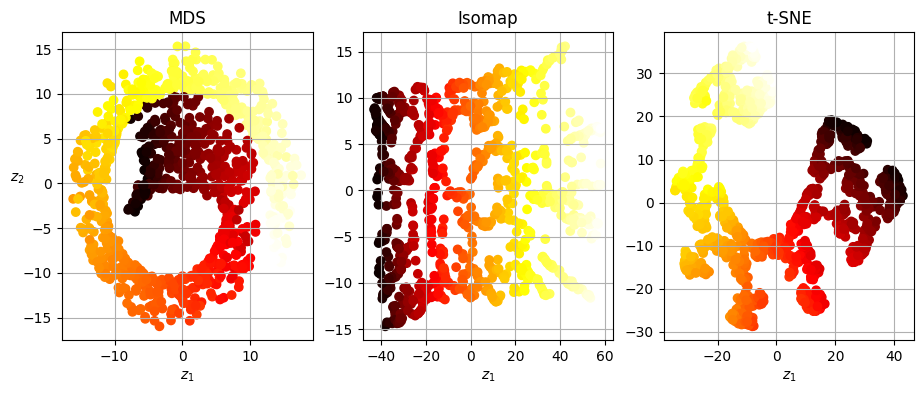

In [34]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='hot')
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()
